# Build and Train a GAN on MNIST

This notebook shows how to generate images of handwritten digits using a [Generative Adversarial Network (GAN)](https://arxiv.org/abs/1701.00160), or more correctly a [Deep Convolutional Generative Adversarial Network (DCGAN)](https://arxiv.org/pdf/1511.06434.pdf). The code here is based on that from the [Tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/dcgan), it is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a custom [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) training loop to implement the adversarial training required.

## Please note: there is a [graded exercise](#graded_exercise) at the end of this notebook.

The graded exercise requires you to adapt this notebook to train a GAN on a different dataset and upload your adapted notebook to Brightspace.

## Setup the Environment

We begin by importing the usual libraries; Tensorflow 2, MatPlotLib, and NumPy. In addition, this notebook makes use of access to the filesystem for saving checkpoints to support this we import libraries for dealing with the operating system, and dealing with time.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In addition to the standard libraries imported above, this notebook will make use of a library that allows us to plot a graph of the losses over time as the GAN is trained. To do this we must first install the library on the local system because it is not included with the standard installation on Colab runtimes. This is done with the `!pip install` command.

In [2]:
!pip install livelossplot --quiet

from livelossplot import PlotLosses

### Load and prepare the MNIST dataset

We will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data. To load the dataset we use Keras, which will load the dataset into memory. This works well for the small datasets available through Keras. For larger datasets, e.g., [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), we would use the [tensorflow_datasets](https://www.tensorflow.org/datasets) library to download and cache the dataset on the local filesystem.

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


#### Prepare the dataset

The MNIST dataset needs to transformed for use with convolutional networks, i.e., the image data needs to be reshaped from a flat vector to a 28x28x1 image and the datatype converted to a 32-bit floating point number. This is the same as we did for the VAE trained on the MNIST dataset. Unlike the VAE example the individual pixel values are normalised into the range \[-1, 1\], rather than \[0, 1\] for the VAE. Experimentally this range has proved to be better for training GANs.

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

#### Define some constants

We transform the prepared images into a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). This will take care of sampling the prepared MNIST images by shuffling a buffer of inputs (the size of the buffer is controlled by `BUFFER_SIZE`) and providing batches for use in training of size `BATCH_SIZE`.

In [5]:
# Maximum dataset size is 60000
DATASET_SIZE = 10000
BATCH_SIZE = 256

In [6]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images[:DATASET_SIZE]).shuffle(DATASET_SIZE).batch(BATCH_SIZE)

## Build the Generative Adversarial Network (GAN)

The GAN is built in two halves, the generator and the discriminator. In this example, both the generator and discriminator are relatively simple and have a linear structure and so are defined using the [Keras Sequential API](https://keras.io/guides/sequential_model/). Typically, the complexity of using GANs is the custom training required to support the adversarial learning, as we'll see in the next section.

### Build the Generator

The generator is a convolutional network that takes as input a noise vector and outputs an image for the discriminator. First, we define the size of the noise vectors that are provided to the generator as input.

In [7]:
NOISE_DIM = 100

Next we define a function that will build the generator model. The generator uses [`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers to upsample from a seed (random noise) to produce an image of the same size as those in the MNIST dataset, i.e., 28x28x1. The generator starts with a [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layer that takes this seed as input and then upsamples several times until the desired image size of 28x28x1 is reached. Notice the [`tf.keras.layers.LeakyReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) activation for each layer, except the output layer which uses `tanh`, which will output a value between -1 and 1 to match the preprocessed MNIST images.

In [8]:
def build_generator(noise_dim=100):
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

To test that the generator model is working, we can input a random vector of size `NOISE_DIM`, produced by sampling from the standard normal distribution, and display the image produced. Unsurprisingly, before any training the output of the generator is an image of noise.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

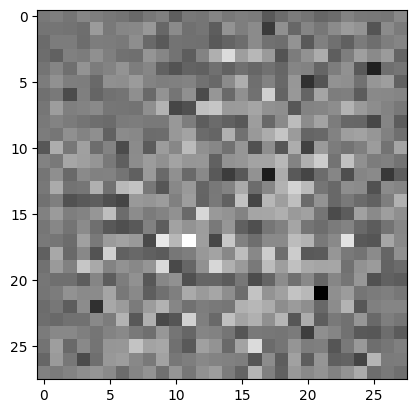

In [9]:
generator = build_generator(NOISE_DIM)

generator.summary()

noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Build the Discriminator

The discriminator is an image classifier, which has two convolutional layers, with [`LeakyReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) activation and 30% [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout). The discriminator takes as inputs with a shape of 28x28x1 and outputs a single value, which represents a decision about whether the input has been sampled from the MNIST dataset directly (i.e. is real) or has been generated by the generator (i.e. is fake). A value of 1 represents a real input and 0 represents a fake output.

In [10]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

To test that the discrimiator is working we can provide it with the `generated_image` created earlier as input and check that we get a single value as its output.

In [11]:
discriminator = build_discriminator()
decision = discriminator(generated_image)
print(decision)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.00200759]], shape=(1, 1), dtype=float32)


### Define the Loss and Optimisers

Define loss functions and optimizers for both the generator and the discriminator. We start by defining a helper function for computing the Binary Crossentropy loss. Note the use of `from_logits=True`, this indicates that the values provided have not been passed through a `SoftMax` function, i.e., they do not represent a probability. This makes sense for this case because there is just one output from the network.

In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real from fake inputs. Given a batches of real and fake outputs, it compares the discriminator's predictions on real inputs to an array of 1s, and the discriminator's predictions on fake (generated) inputs to an array of 0s. The loss is simply the sum of the losses on the real and fake inputs.

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### Generator Loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). So, instead of comparing the discriminators decisions on fake (generated) inputs against an array of 0s, as for the descriminator loss, it compares the discriminators decisions on the generated images to an array of 1s.

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The optimisers for the discriminator and the generator are different because they are trained separately, and so need to keep separate metrics for training momentum, etc.

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### Save checkpoints

It can be very helpful in case a long running training tasks, such as when training GANs, to save checkpoints, so that training can be restarted should it be interrupted. This notebook demonstrates how to set this up.

Note that the checkpoints saved here will not persist a restart of the Colab runtime, which does not maintain the contents of the filesystem. To make better use of checkpoints, either [link your Google Drive to your Colab runtime](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA) to provide persistent storage, or [setup a local Jupyter notebook server](https://jupyter.org) as your development environment (if you have a sufficiently powerful GPU to support machine learning).

#### Linking your Google Drive

Linking your Google Drive to a Colab runtime is relatively simple and will provide the easiest way to save checkpoints for the future. Evaluating the following code in a cell will prompt you to permit the runtime permission to access your Google Drive:

    from google.colab import drive
    drive.mount('/content/drive')

Files can then be saved to the directory `/content/drive/My\ Drive/` and it will appear in your Google Drive. For example, after granting permission, the following will create a file called `foo.txt` in the root of your Google Drive:

    with open('/content/drive/My Drive/foo.txt', 'w') as f:
      f.write('Hello Google Drive!')
    !cat /content/drive/My\ Drive/foo.txt

Don't forget to unmount your Google Drive once your done saving files, e.g., at the end of a training session. This will ensure that all of the data has been saved:

    drive.flush_and_unmount()

In [16]:
checkpoint_dir = './drive/MyDrive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
checkpoint_prefix

'./drive/MyDrive/training_checkpoints/ckpt'

### Define the training loop


First we define some constants for the training loop. The total number of epochs and the number of epochs between saving checkpoints.

In [19]:
EPOCHS = 50
EPOCHS_BETWEEN_CHECKPOINTS = 10

This function defines the custom training step required for GANs to take care of the training of both the generator and discriminator. The function takes as input a batch of real images (drawn from the training set), which are used to train only the discriminator.

The training step begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [20]:
# Notice the use of the `tf.function` decorator
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

#### Training the GAN

The `train()` function defines a simple training loop, which iterates through the dataset in batches for the given number of epochs. This function tracks the losses of the generator and discriminator and reports on it for each epoch. The function also saves a checkpoint every few epochs.

In [21]:
def train(dataset, epochs):
  epoch_gen_loss = tf.keras.metrics.Mean(name="epoch_gen_loss")
  epoch_disc_loss = tf.keras.metrics.Mean(name="epoch_disc_loss")

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      epoch_gen_loss.update_state(gen_loss)
      epoch_disc_loss.update_state(disc_loss)

    mean_gen_loss = epoch_gen_loss.result()
    mean_disc_loss = epoch_disc_loss.result()

    # Save the model every few epochs (EPOCHS_BETWEEN_CHECKPOINTS)
    if (epoch + 1) % EPOCHS_BETWEEN_CHECKPOINTS == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} in {} sec, gen_loss = {}, disc_loss = {}'.format(epoch + 1, time.time()-start, mean_gen_loss, mean_disc_loss))
    epoch_gen_loss.reset_state()
    epoch_disc_loss.reset_state()

Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

In [22]:
train(train_dataset, 10)

Epoch 1 in 7.081950426101685 sec, gen_loss = 0.543114960193634, disc_loss = 1.1034176349639893
Epoch 2 in 0.4610564708709717 sec, gen_loss = 0.5616486668586731, disc_loss = 1.2032972574234009
Epoch 3 in 0.46365880966186523 sec, gen_loss = 0.65147465467453, disc_loss = 1.1014069318771362
Epoch 4 in 0.46623730659484863 sec, gen_loss = 0.8263362050056458, disc_loss = 1.1024019718170166
Epoch 5 in 0.4617469310760498 sec, gen_loss = 0.6965095400810242, disc_loss = 1.3062797784805298
Epoch 6 in 0.47581958770751953 sec, gen_loss = 0.7274608016014099, disc_loss = 1.180292010307312
Epoch 7 in 0.47372937202453613 sec, gen_loss = 0.6807550191879272, disc_loss = 1.4017846584320068
Epoch 8 in 0.46436238288879395 sec, gen_loss = 0.7031455636024475, disc_loss = 1.399297833442688
Epoch 9 in 0.466113805770874 sec, gen_loss = 0.8095992803573608, disc_loss = 1.167855978012085
Epoch 10 in 2.750706195831299 sec, gen_loss = 0.8236172795295715, disc_loss = 1.1614136695861816


#### Plotting the losses during training

By default the training set is only 10,000 samples from the full dataset, however, based on previous experience we might expect the loss values to decrease over time. To confirm this we might want to plot the values of the loss. The following alternative training function `train_with_plot()` uses the `livelossplot` library we loaded at the start.

In [23]:
def train_with_plot(dataset, epochs):
  plotlosses = PlotLosses(from_step=2, groups={'loss':['gen_loss','disc_loss']})
  epoch_gen_loss = tf.keras.metrics.Mean(name="epoch_gen_loss")
  epoch_disc_loss = tf.keras.metrics.Mean(name="epoch_disc_loss")

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      epoch_gen_loss.update_state(gen_loss)
      epoch_disc_loss.update_state(disc_loss)

    total_gen_loss = epoch_gen_loss.result()
    total_disc_loss = epoch_disc_loss.result()

    # Save the model every few epochs (EPOCHS_BETWEEN_CHECKPOINTS)
    if (epoch + 1) % EPOCHS_BETWEEN_CHECKPOINTS == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print('Epoch {} in {} sec, gen_loss = {}, disc_loss = {}'.format(epoch + 1, time.time()-start, total_gen_loss, total_disc_loss))
    plotlosses.update({'gen_loss': total_gen_loss, 'disc_loss': total_disc_loss})
    plotlosses.send()
    epoch_gen_loss.reset_state()
    epoch_disc_loss.reset_state()

To get a better picture of the change in loss over time, we can run this new training function over more epochs. To be completely sure that the lack of improvement in loss is not a product of the small dataset you may want to redefine `train_dataset` after changing the value for `DATASET_SIZE`.

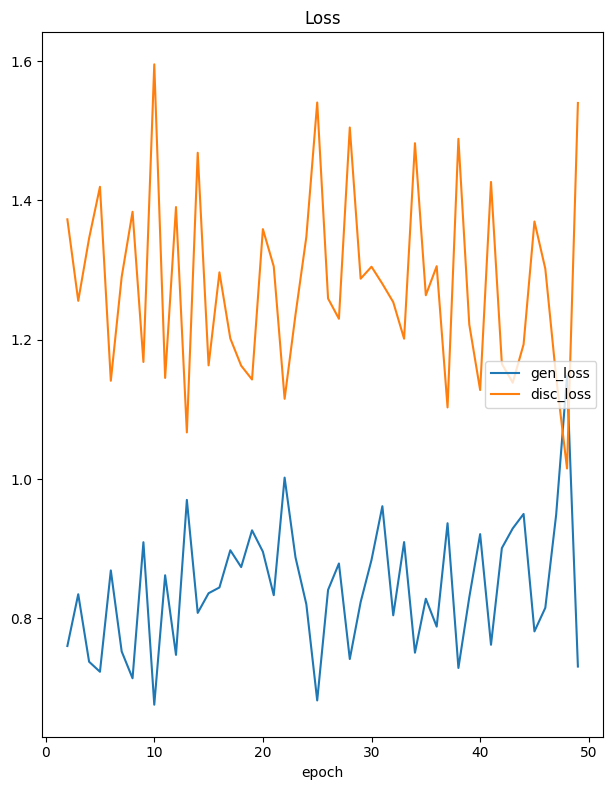

Loss
	gen_loss         	 (min:    0.676, max:    1.148, cur:    0.731)
	disc_loss        	 (min:    1.015, max:    1.595, cur:    1.540)


In [24]:
train_with_plot(train_dataset, EPOCHS)

So what is happening? The changes in loss for the generator and discriminator are clearly related, almost mirroring each other around a value of 1.

If we think back to the definitions for `generator_loss()` and `discriminator_loss()`, which are defined in opposition with respect to the discriminator's ability to determine whether an image is generated. The differences between the changes in loss can be accounted for by the additional loss for the discriminator that penalises the misattribution of real images as fake.

Over time, as the generator and discriminator train and adapt to each other the losses may tend towards 1. In general, we want the networks to remained balanced, so monitoring the losses can be helpful but may not be conclusive that the training is complete at any particular point. This is another reason why it is helpful to save checkpoints. We can test the GAN and if it appears to require further training we can pick up where we left off.

#### Visualising the progress of the GAN training

To get a better understanding of the progress being made by the GAN we can visualise the output of the generator and see how it becomes increasingly like the target dataset.

We begin by defining some constants to control the number of examples to generate after each epoch. A seed array of normally distributed noise vectors is also defined so that the generator is given the same input each time the images are produced.

In [25]:
NUM_EXAMPLES_TO_GENERATE = 16

# Reusing this seed allows the progress of the network to be visualize
# by generating images given the same inputs each time
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

The following function generates and saves the images to the local filesystem.

In [26]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

This third variant of the training function uses the above function to generate and save a sample of images every epoch.

In [27]:
from IPython import display

def train_with_images(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 10 epochs
    if (epoch + 1) % EPOCHS_BETWEEN_CHECKPOINTS == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

## Train the model

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

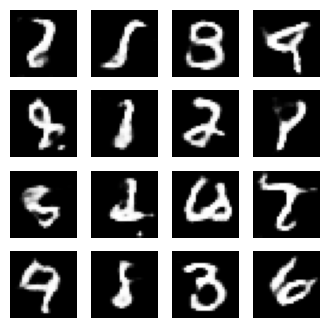

In [28]:
# Uncomment the following to redefine the train_dataset to include all of the dataset
DATASET_SIZE = 60000
train_dataset = tf.data.Dataset.from_tensor_slices(train_images[:DATASET_SIZE]).shuffle(DATASET_SIZE).batch(BATCH_SIZE)

# Uncomment the following to increase the number of epochs the network will train for
EPOCHS = 100

train_with_images(train_dataset, EPOCHS)

#### Using checkpoints

The following code will restore the last checkpoint saved into the checkpoint directory.

In [29]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#### Display saved images

We can display the saved images for any of the epochs using the `IPython.display.Image` library to open the image and display it in the notebook.

In [30]:
from IPython.display import Image

def display_image_at_epoch(epoch_no):
  return Image(filename='image_at_epoch_{:04d}.png'.format(epoch_no))

For example, we can display the sample image for the final epoch using this function.

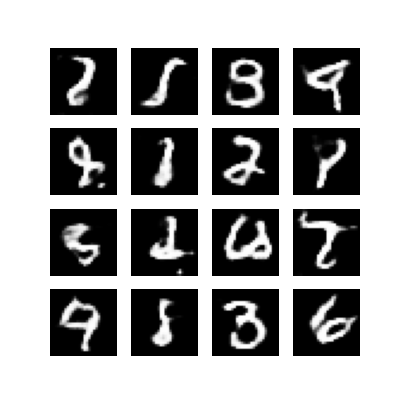

In [31]:
display_image_at_epoch(EPOCHS)

#### Generate an animated GIF

The `imageio` library can be used to generate an animated GIF using the images saved during training.

In [32]:
import glob
import imageio

anim_file = 'gan_anim.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/tmp/ipython-input-3945368287.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipython-input-3945368287.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Finally, we can display the animated GIF and see how the generator learned to produce increasingly convincing images of handdrawn digits during the training.

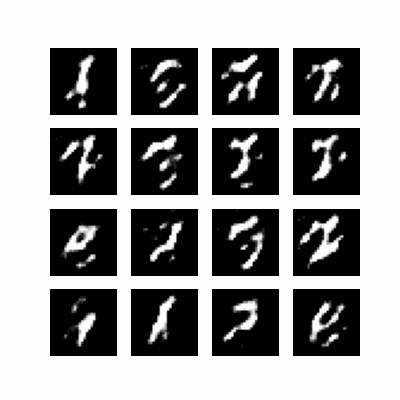

In [33]:
Image(open(anim_file, 'rb').read())

## Summary

This notebook has shown how we can construct a Deep Convolutional Generative Adversarial Network (DCGAN) and train it on the MNIST dataset of hadndrawn digits.

This notebook shows how the design of the generator and discriminator networks are similar other types of convolutional networks, but the training loop is quite different due to the need to provide the discriminator with real and fake (generated) images and for the loss of the generator to be defined based on the performance of the discriminator.

The most difficult aspect of using GANs is balancing the training of the generator and discriminator and monitoring metrics such as loss only provides a crude measure of how well the training is progressing because the loss of the generator and discriminator will not converge towards 0, due to the adversarial nature of the training.

#Additional work

In [47]:
# --- Optimizers (TTUR) ---
g_opt_w = tf.keras.optimizers.Adam(1e-4, beta_1=0.0, beta_2=0.9)
d_opt_w = tf.keras.optimizers.Adam(2e-4, beta_1=0.0, beta_2=0.9)

LAMBDA_GP = 10.0
CRITIC_STEPS = 5

# --- WGAN-GP losses ---
@tf.function
def wgan_d_loss(real_out, fake_out):
    # maximize real_out - fake_out  <=>  minimize fake - real
    return tf.reduce_mean(fake_out) - tf.reduce_mean(real_out)

@tf.function
def wgan_g_loss(fake_out):
    # maximize fake_out  <=>  minimize -fake_out
    return -tf.reduce_mean(fake_out)

# --- Gradient penalty ---
def gradient_penalty(critic, real, fake):
    eps = tf.random.uniform([tf.shape(real)[0], 1, 1, 1], 0.0, 1.0)
    x_hat = eps * real + (1.0 - eps) * fake
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(x_hat)
        pred = critic(x_hat, training=True)
    grads = gp_tape.gradient(pred, x_hat)
    # ||grad||2 per-sample
    norm = tf.sqrt(1e-12 + tf.reduce_sum(tf.square(grads), axis=[1,2,3]))
    gp = tf.reduce_mean(tf.square(norm - 1.0))
    return gp

# --- Training steps (critic & generator) ---
@tf.function
def critic_step(real_batch):
    noise = tf.random.normal([tf.shape(real_batch)[0], NOISE_DIM])
    with tf.GradientTape() as tape:
        fake = generator(noise, training=True)
        real_out = discriminator(real_batch, training=True)
        fake_out = discriminator(fake, training=True)
        gp = gradient_penalty(discriminator, real_batch, fake)
        d_loss = wgan_d_loss(real_out, fake_out) + LAMBDA_GP * gp
    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    d_opt_w.apply_gradients(zip(grads, discriminator.trainable_variables))
    return d_loss

@tf.function
def generator_step():
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as tape:
        fake = generator(noise, training=True)
        fake_out = discriminator(fake, training=True)
        g_loss = wgan_g_loss(fake_out)
    grads = tape.gradient(g_loss, generator.trainable_variables)
    g_opt_w.apply_gradients(zip(grads, generator.trainable_variables))
    return g_loss

# --- Handy utils (images & simple metrics) ---
def denorm01(x):  # [-1,1] -> [0,1]
    return (x + 1.0) * 0.5

def sample_fake(n=10000):
    imgs = []
    for _ in range(int(np.ceil(n / BATCH_SIZE))):
        z = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        g = generator(z, training=False)
        imgs.append(g.numpy())
    x = np.concatenate(imgs, axis=0)[:n]
    return denorm01(x)  # (n,28,28,1) in [0,1]

def sample_real(n=10000):
    # train_images are in [-1,1]; convert to [0,1]
    idx = np.random.choice(train_images.shape[0], n, replace=False)
    x = train_images[idx]
    return denorm01(x)  # (n,28,28,1)

# --- PATCH: robust embedder loader (fixes .numpy() on numpy arrays) ---
# --- PATCH: functional API embedder (robust, no "never been called" error) ---
def get_mnist_embedder(train_x=None, train_y=None, epochs=1):
    inp = tf.keras.Input(shape=(28,28,1))
    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(inp)
    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    emb = tf.keras.layers.Dense(128, activation='relu', name='embedding')(x)
    out = tf.keras.layers.Dense(10, activation='softmax')(emb)
    model = tf.keras.Model(inp, out)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    if train_x is None:
        x = denorm01(train_images[:50000])   # [-1,1] -> [0,1]
        if isinstance(x, tf.Tensor):
            x = x.numpy()
        x = x.astype('float32')
        y = train_labels[:50000].astype('int64')
    else:
        x, y = train_x, train_y

    model.fit(x, y, epochs=epochs, batch_size=256, verbose=0)

    # build embedding model (has valid .inputs via Functional)
    embed = tf.keras.Model(model.inputs, model.get_layer('embedding').output)
    return embed, model

def frechet_distance(mu1, sigma1, mu2, sigma2):
    # FID = ||mu1-mu2||^2 + Tr(sigma1 + sigma2 - 2*sqrt(sigma1*sigma2))
    try:
        from scipy.linalg import sqrtm
        covmean = sqrtm(sigma1.dot(sigma2))
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        diff = mu1 - mu2
        return diff.dot(diff) + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    except Exception as e:
        # Fallback: "FID-lite" (drop cross term)
        print("[warn] SciPy sqrtm unavailable -> using FID-lite (upper bound).", e)
        diff = mu1 - mu2
        return diff.dot(diff) + np.trace(sigma1 + sigma2)

def eval_fid_and_hist(n_eval=10000):
    embed, clf = get_mnist_embedder(epochs=1)
    real = sample_real(n_eval)
    fake = sample_fake(n_eval)
    # embeddings
    er = embed(real, training=False).numpy()
    ef = embed(fake, training=False).numpy()
    mu_r, mu_f = er.mean(axis=0), ef.mean(axis=0)
    sr = np.cov(er, rowvar=False)
    sf = np.cov(ef, rowvar=False)
    fid = frechet_distance(mu_r, sr, mu_f, sf)
    # class histogram on fakes
    preds = np.argmax(clf.predict(fake, verbose=0), axis=1)
    hist = np.bincount(preds, minlength=10) / len(preds)
    return fid, hist

def save_grid(imgs, path="samples_grid.png", rows=4, cols=4):
    fig = plt.figure(figsize=(4,4))
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    fig.savefig(path, dpi=200)
    plt.close(fig)

# --- WGAN-GP training loop with periodic sampling & metrics ---
def train_wgangp(dataset, epochs=20, steps_per_epoch=None, eval_every=5):
    if steps_per_epoch is None:
        # derive from your DATASET_SIZE and BATCH_SIZE
        steps_per_epoch = int(np.ceil(float(DATASET_SIZE) / float(BATCH_SIZE)))
    data_iter = iter(dataset.repeat())
    for epoch in range(1, epochs+1):
        start = time.time()
        for _ in range(steps_per_epoch):
            # multiple critic steps
            for _ in range(CRITIC_STEPS):
                real = next(data_iter)
                d_loss = critic_step(real)
            g_loss = generator_step()
        # sample & save a grid
        gimgs = generator(seed, training=False).numpy()
        gimgs = denorm01(gimgs)
        save_grid(gimgs, path=f'wgangp_epoch_{epoch:03d}.png', rows=4, cols=4)
        # periodic metrics
        if epoch % eval_every == 0:
            fid, hist = eval_fid_and_hist(n_eval=5000)
            print(f"[WGAN-GP] epoch {epoch:03d} | g_loss {g_loss.numpy():.3f} | d_loss {d_loss.numpy():.3f} | FID~ {fid:.2f} | class_hist {np.round(hist,2)}")
        else:
            print(f"[WGAN-GP] epoch {epoch:03d} | g_loss {g_loss.numpy():.3f} | d_loss {d_loss.numpy():.3f} | {time.time()-start:.1f}s")

[WGAN-GP] epoch 001 | g_loss -4.182 | d_loss -0.508 | 33.1s
[WGAN-GP] epoch 002 | g_loss -4.185 | d_loss -0.543 | 28.5s
[WGAN-GP] epoch 003 | g_loss -4.158 | d_loss -0.421 | 28.7s
[WGAN-GP] epoch 004 | g_loss -4.336 | d_loss -0.604 | 28.9s


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_144']
Received: inputs=Tensor(shape=(5000, 28, 28, 1))
  warnings.warn(msg)
/tmp/ipython-input-2763274070.py:111: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = sqrtm(sigma1.dot(sigma2))


[WGAN-GP] epoch 005 | g_loss -3.487 | d_loss -0.638 | FID~ 0.28 | class_hist [0.09 0.12 0.07 0.08 0.08 0.12 0.13 0.11 0.11 0.09]
[WGAN-GP] epoch 006 | g_loss -3.911 | d_loss -0.443 | 29.0s
[WGAN-GP] epoch 007 | g_loss -3.555 | d_loss -0.638 | 29.0s
[WGAN-GP] epoch 008 | g_loss -4.308 | d_loss -0.355 | 29.3s
[WGAN-GP] epoch 009 | g_loss -3.954 | d_loss -0.511 | 28.8s


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_152']
Received: inputs=Tensor(shape=(5000, 28, 28, 1))
  warnings.warn(msg)


[WGAN-GP] epoch 010 | g_loss -4.447 | d_loss -0.423 | FID~ 0.43 | class_hist [0.08 0.11 0.12 0.1  0.11 0.11 0.13 0.08 0.1  0.05]
[WGAN-GP] epoch 011 | g_loss -4.279 | d_loss -0.363 | 29.1s
[WGAN-GP] epoch 012 | g_loss -4.925 | d_loss -0.344 | 29.1s
[WGAN-GP] epoch 013 | g_loss -5.053 | d_loss -0.678 | 29.0s
[WGAN-GP] epoch 014 | g_loss -4.829 | d_loss -0.441 | 29.0s


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_160']
Received: inputs=Tensor(shape=(5000, 28, 28, 1))
  warnings.warn(msg)


[WGAN-GP] epoch 015 | g_loss -4.175 | d_loss -0.306 | FID~ 0.42 | class_hist [0.13 0.09 0.21 0.08 0.17 0.06 0.06 0.08 0.04 0.09]
[WGAN-GP] epoch 016 | g_loss -4.002 | d_loss -0.353 | 29.1s
[WGAN-GP] epoch 017 | g_loss -3.871 | d_loss -0.467 | 29.6s
[WGAN-GP] epoch 018 | g_loss -4.129 | d_loss -0.379 | 28.9s
[WGAN-GP] epoch 019 | g_loss -3.069 | d_loss -0.468 | 28.9s


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_168']
Received: inputs=Tensor(shape=(5000, 28, 28, 1))
  warnings.warn(msg)


[WGAN-GP] epoch 020 | g_loss -4.315 | d_loss -0.437 | FID~ 0.08 | class_hist [0.18 0.13 0.04 0.1  0.08 0.07 0.06 0.12 0.11 0.12]
[WGAN-GP] epoch 021 | g_loss -3.471 | d_loss -0.326 | 29.0s
[WGAN-GP] epoch 022 | g_loss -3.788 | d_loss -0.327 | 29.0s
[WGAN-GP] epoch 023 | g_loss -3.956 | d_loss -0.438 | 28.9s
[WGAN-GP] epoch 024 | g_loss -4.196 | d_loss -0.369 | 29.0s


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_176']
Received: inputs=Tensor(shape=(5000, 28, 28, 1))
  warnings.warn(msg)


[WGAN-GP] epoch 025 | g_loss -3.833 | d_loss -0.424 | FID~ 0.15 | class_hist [0.06 0.13 0.08 0.1  0.13 0.07 0.11 0.11 0.13 0.08]
[WGAN-GP] epoch 026 | g_loss -4.053 | d_loss -0.327 | 29.1s
[WGAN-GP] epoch 027 | g_loss -2.986 | d_loss -0.549 | 29.1s
[WGAN-GP] epoch 028 | g_loss -3.136 | d_loss -0.386 | 28.9s
[WGAN-GP] epoch 029 | g_loss -2.391 | d_loss -0.561 | 29.0s


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_184']
Received: inputs=Tensor(shape=(5000, 28, 28, 1))
  warnings.warn(msg)


[WGAN-GP] epoch 030 | g_loss -3.853 | d_loss -0.392 | FID~ 0.31 | class_hist [0.07 0.13 0.06 0.1  0.06 0.1  0.1  0.16 0.07 0.14]


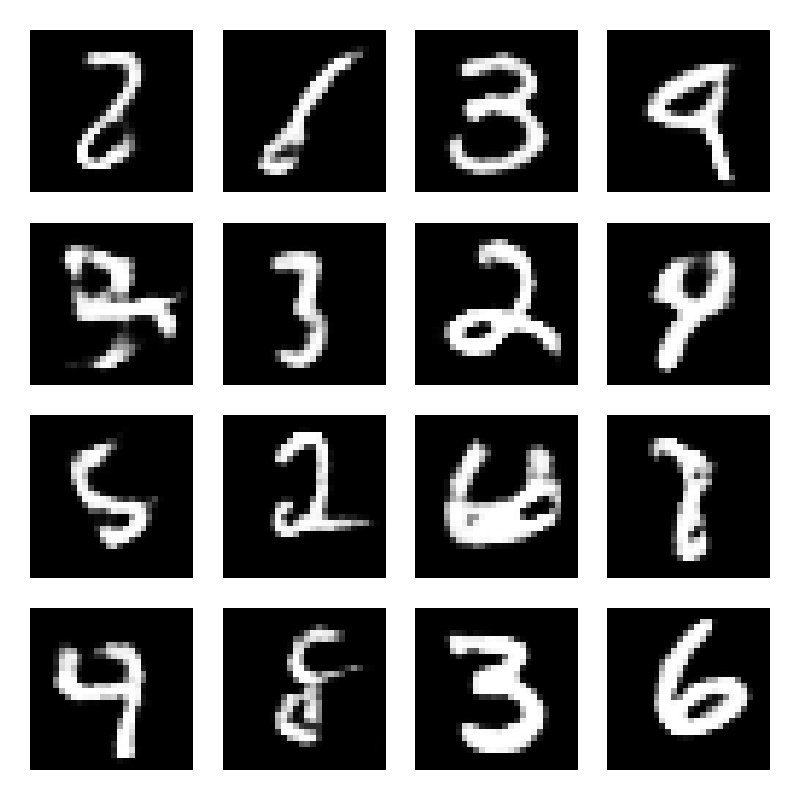

In [48]:
EPOCHS = 30  # try small first
train_wgangp(train_dataset, epochs=EPOCHS, eval_every=5)

# After training, show the last generated grid
from IPython.display import Image
Image("wgangp_epoch_{:03d}.png".format(EPOCHS))


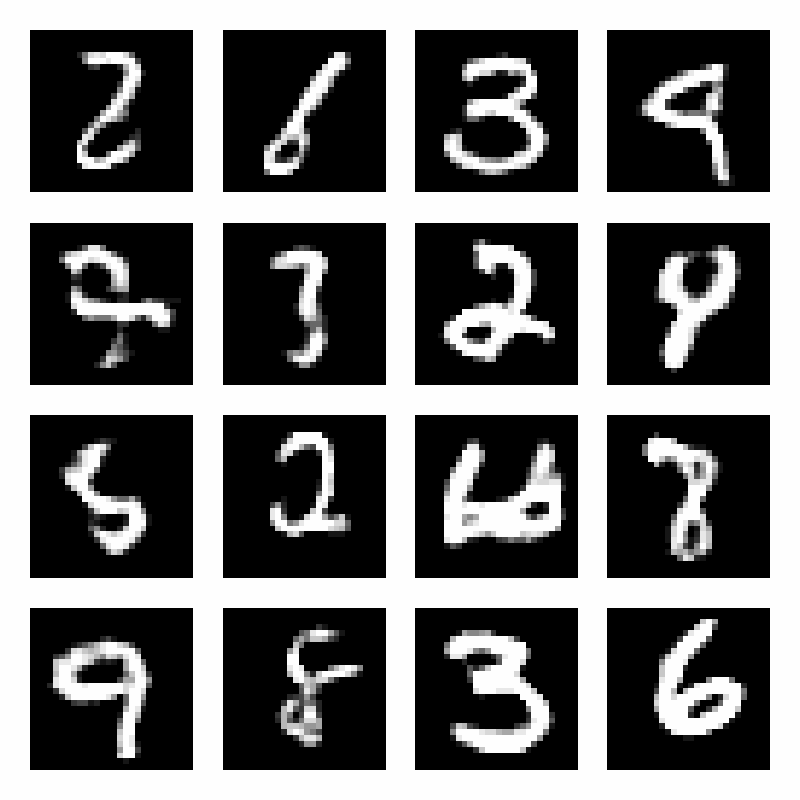

In [49]:
import glob, imageio, os
from IPython.display import Image as IPyImage

# Collect saved grids (from the upgraded trainer)
frames = sorted(glob.glob("wgangp_epoch_*.png"))

# Optional: subsample if you saved many epochs (e.g., every 2nd frame)
# frames = frames[::2]

assert len(frames) > 0, "No saved frames found. Make sure train_wgangp() ran and saved wgangp_epoch_XXX.png files."

gif_path = "wgangp_training.gif"
with imageio.get_writer(gif_path, mode="I", duration=0.2) as writer:
    for f in frames:
        writer.append_data(imageio.v2.imread(f))
    # linger on last frame
    writer.append_data(imageio.v2.imread(frames[-1]))

# Show inline
IPyImage(filename=gif_path)
